In [2]:
# Import used labraries
import pandas as pd 
import numpy as np 
from sklearn.model_selection import KFold # kfold for model validation
from sklearn.model_selection import train_test_split # for data spliting
from sklearn.preprocessing import StandardScaler # for data normalization 
import matplotlib.pyplot as plt

# Sklearn modules 
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Sklearn accuracy 
from sklearn.metrics import accuracy_score
from collections import Counter

# Automatically create polynomial features! 
from sklearn.preprocessing import PolynomialFeatures


# Import Regularized regression function
from sklearn.linear_model import LassoCV

# ML pipeline
from sklearn.pipeline import make_pipeline

#set display 
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
# Load csv into dataframes 
df_data = pd.read_csv("../dat/2021VAERSDATA.csv", sep=',',thousands=',', error_bad_lines=False, index_col=False, dtype='unicode')
df_sympt = pd.read_csv("../dat/2021VAERSSYMPTOMS.csv", sep=',',thousands=',', error_bad_lines=False, index_col=False, dtype='unicode')

# use this df to select covid19 vaccines
df_vax = pd.read_csv("../dat/2021VAERSVAX.csv", sep=',',thousands=',', error_bad_lines=False, index_col=False, dtype='unicode')

In [4]:
# print shape info for each dataframe 
print('2021VAERSDATA shape ',df_data.shape[0],' rows ' ,df_data.shape[1],' columns ') 
print('2021VAERSSYMPTOMS shape ',df_sympt.shape[0],' rows ' ,df_sympt.shape[1],' columns ') 
print('2021VAERSVAX shape ',df_vax.shape[0],' rows ' ,df_vax.shape[1],' columns ')

2021VAERSDATA shape  747180  rows  35  columns 
2021VAERSSYMPTOMS shape  999509  rows  11  columns 
2021VAERSVAX shape  791183  rows  8  columns 


In [5]:
# select covid19 vaccines which are used in germany 'PFIZER\\BIONTECH' 'MODERNA' 'JANSSEN' AstraZeneca is not listed here !
vax_names = ['PFIZER\\BIONTECH','MODERNA','JANSSEN']
df_vax_cols = ['VAERS_ID','VAX_MANU']
df_tep = df_vax[(df_vax['VAX_TYPE'] == 'COVID19') & (df_vax['VAX_DOSE_SERIES'] == '3') & (df_vax['VAX_MANU'].isin(vax_names))]
df_vax_selected = df_tep[df_vax_cols]
df_vax_selected.VAX_MANU = pd.Categorical(df_vax_selected['VAX_MANU'])
df_vax_selected.VAX_MANU = df_vax_selected.VAX_MANU.cat.codes
df_vax_selected.VAERS_ID = df_vax_selected.VAERS_ID.astype('str')

df_vax_selected.reset_index(drop=True, inplace=True)


C:\Users\eliaa\Anaconda3\lib\site-packages\pandas\core\generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [6]:
df_vax_selected.head()
df_vax_selected['VAX_MANU'].value_counts()[:5].sort_values(ascending=False)

2    19740
1    17872
0      169
Name: VAX_MANU, dtype: int64

In [7]:
# select the top 7 common symptoms 
# selcted_symptoms =  ['Chills', 'Pyrexia', 'Dizziness', 'Fatigue', 'Headache', 'Pain in extremity', 'Nausea']

# def selector(row):
#     selcted_symptoms =  ['Chills', 'Pyrexia', 'Dizziness', 'Fatigue', 'Headache', 'Pain in extremity', 'Nausea']
#     if row.isin(selcted_symptoms):
#         return row
#     else:
#         return 'Other'

# symptoms_selected_cols = ['VAERS_ID','SYMPTOM1','SYMPTOM2','SYMPTOM3','SYMPTOM4','SYMPTOM5']
# symptoms_cols = ['SYMPTOM1','SYMPTOM2','SYMPTOM3','SYMPTOM4','SYMPTOM5']
# df_sympt_filter = df_sympt[symptoms_selected_cols]
# for x in symptoms_cols:
#     df_sympt_filter[x] = df_sympt_filter.apply( lambda row : selector(row), axis = 1)

In [8]:

#df_sympt_filter_selected = df_sympt_filter[symptoms_selected_cols]
# df_sympt_filter.head()

In [9]:
def plot_frec_col(df, colName):
    # plot the histogram of frequencies of values in column label

    # convert the column to a list 
    arr_label = df[colName].to_list()

    # count the values of the prev. list 
    label_labels, label_counts = np.unique(arr_label, return_counts=True)

    # set the general font size to 16
    plt.rcParams['font.size'] = '16'

    # set the figure size 
    plt.figure(figsize=(12,8))

    # plot the values as bar histogram 
    plt.bar(label_labels, label_counts, align='center')

    # set the title of the plot and axes names
    tit = 'Histogram of column '+ str(colName)
    plt.title(tit,fontsize=25)
    plt.xlabel(colName)
    plt.ylabel('frequency')
    plt.setp(plt.gca().get_xticklabels(), rotation=70, horizontalalignment='right')
    plt.gca().set_xticks(label_labels)

    # show the plot 
    plt.show()

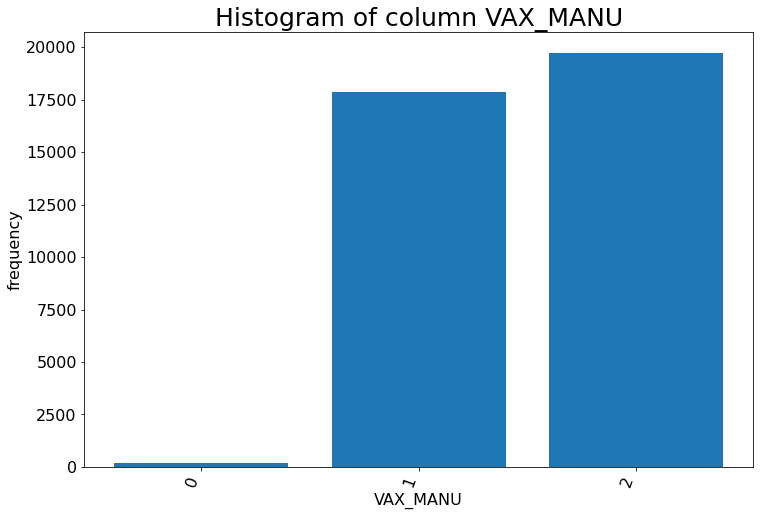

In [10]:
# df_syptm_cols_corr = df_sympt_filter[symptoms_cols]
plot_frec_col(df_vax_selected,'VAX_MANU')

# df_syptm_cols_corr.head(10)

In [11]:
def df_Stat(df):
    # list of dataframe colums names
    col_names=list(df.columns)

    # data types of columns 
    te = list(map(str,df.dtypes))

    # create a list of directories
    dic_list=[]

    # itrate over columns names list and datatypes list and add the entries to a directory and then add this dict. to a list
    for c,t in zip(col_names,te):
        dict_cols_stat = {"name":c,"num_of_distinct_values":len(list(df[c].unique())),"dtype":t}
        dic_list.append(dict_cols_stat)

    # create a new dataframe 
    col_stat_df = pd.DataFrame()

    # for each dict. in dict. list add to the last dataframe 
    for l in dic_list:
        col_stat_df=col_stat_df.append(l, ignore_index=True)
    
    # show column name, its datatype and how many distinct values it has 
    df_st= (col_stat_df[['name','dtype','num_of_distinct_values']]
    .where(col_stat_df.num_of_distinct_values<52)
    .sort_values('num_of_distinct_values').dropna())

    return df_st



In [12]:
df_Stat(df_data)

,name,dtype,num_of_distinct_values
9,DIED,object,2.0
11,L_THREAT,object,2.0
12,ER_VISIT,object,2.0
13,HOSPITAL,object,2.0
15,X_STAY,object,2.0
16,DISABLE,object,2.0
29,FORM_VERS,object,2.0
31,BIRTH_DEFECT,object,2.0
32,OFC_VISIT,object,2.0
33,ER_ED_VISIT,object,2.0


In [13]:
# After cleaning select top 10 + Unknown
df_data_clean = df_data
df_data['HISTORY'].value_counts()[:20].sort_values(ascending=False)
replace_dist_history= {
    'None':'Unknown',
    'none': 'Unknown',
    'Comments: Unknown':'Unknown',
    'No':'Unknown',
    'asthma':'Asthma',
    'mild asthma':'Asthma',
    'Asthma.':'Asthma',
    'Medical History/Concurrent Conditions: Asthma':'Asthma',
    'no':'Unknown',
    'NONE':'Unknown',
    'none.':'Unknown',
    'unknown':'Unknown',
    'Medical History/Concurrent Conditions: No adverse event':'Unknown',
    'Comments: No medical history was provided by the reporter.':'Unknown',
    'hypertension': 'Hypertension',
    'Medical History/Concurrent Conditions: Hypertension': 'Hypertension',
    'None.' : 'Unknown',
    'diabetes': 'Diabetes',
    'Type 1 diabetes': 'Diabetes',
    'Diabetes type 2': 'Diabetes',
    'Diabetes Type 2': 'Diabetes',
    'Type 1 Diabetes': 'Diabetes',
    'Type 2 Diabetes':'Diabetes',
    'Type 2 diabetes':'Diabetes',
    'Medical History/Concurrent Conditions: Diabetes': 'Diabetes',
    'Medical History/Concurrent Conditions: No adverse event (No reported medical history)':'Unknown',
    'Medical History/Concurrent Conditions: Anxiety':'Anxiety',
    'High blood pressure':'Hypertension',
    'HIGH BLOOD PRESSURE':'Hypertension',
    'HYPERTENSION':'Hypertension',
    'high blood pressure':'Hypertension',
    'High Blood Pressure' : 'Hypertension',
    'High blood pressure.': 'Hypertension',
    'High BP':'Hypertension',
    'Medical History/Concurrent Conditions: Blood pressure high':'Hypertension',
    'hypothyroidism': 'Hypothyroidism',
    'Medical History/Concurrent Conditions: COVID-19':'COVID-19',
    'Medical History/Concurrent Conditions: COVID-19 (Prior to vaccination, was the patient diagnosed with COVID-19?:Yes)':'COVID-19',
    'Medical History/Concurrent Conditions: COVID-19 (Prior to vaccination, was the patient diagnosed with COVID-19?: Yes)':'COVID-19',
    'Medical History/Concurrent Conditions: No adverse event (No medical history reported)':'Unknown',
    'Medical History/Concurrent Conditions: No adverse event (No reported medical history.)' : 'Unknown',
    'Comments: List of non-encoded Patient Relevant History: Patient Other Relevant History 1: none':'Unknown',
    'Comments: List of non-encoded Patient Relevant History: Patient Other Relevant History 1: None, Comment: Patient History: No':'Unknown',
    'Medical History/Concurrent Conditions: Rheumatoid arthritis':'Rheumatoid Arthritis',
    'Comments: No medical history was reported by the reporter.':'Unknown',
    'Comments: No medical history information was reported.':'Unknown',
    'Medical History/Concurrent Conditions: Migraine':'Migraines',
    'Mild asthma':'Asthma',
    'NONE REPORTED':'Unknown',
    'none listed':'Unknown',
    'denies':'Denies',
    'Comments: The patient had no known allergies.':'Unknown',
    'Medical History/Concurrent Conditions: No adverse event (no reported medical history)':'Unknown',
    'Comments: List of non-encoded Patient Relevant History: Patient Other Relevant History 1: None':'Unknown',
    'Medical History/Concurrent Conditions: No adverse event (No recorded medical history)':'Unknown',
    'Medical History/Concurrent Conditions: No adverse event (no medical history provided)':'Unknown',
    'Medical History/Concurrent Conditions: No adverse event (no medical history reported)':'Unknown',
    'Medical History/Concurrent Conditions: No adverse event (No medical history provided)':'Unknown',
    'Comments: No Medical History Information was reported.':'Unknown',
    'Comments: List of non-encoded Patient Relevant History: Patient Other Relevant History 1: None.':'Unknown',
    'Comments: List of non-encoded Patient Relevant History: Patient Other Relevant History 1: No':'Unknown',
    'Medical History/Concurrent Conditions: No adverse reaction':'Unknown',
    'Comments: No medical history was reported':'Unknown',
    'Medical History/Concurrent Conditions: No adverse event (No medical history was reported.':'Unknown',
    'Not known':'Unknown',
    'NOT KNOWN':'Unknown',
    'None Reported':'Unknown',
    'None Known':'Unknown',
    'Medical History/Concurrent Conditions: No adverse event.':'Unknown',
    'rheumatoid arthritis':'Rheumatoid Arthritis',
    'Medical History/Concurrent Conditions: Depression':'Depression',
    'Comments: No Medical History was provided by the reporter.':'Unknown',
    'diabetic':'Diabetic',
    'Comments: Medical history was not provided.':'Unknown',
    'Comments: No medical history was provided by reporter.':'Unknown',
    'Medical History/Concurrent Conditions: Arthritis':'Arthritis',
    'Comments: No medical history was provided by the reporter':'Unknown',
    'Medical History/Concurrent Conditions: No adverse event (No medical history reported.)':'Unknown',
    'Comments: No medical history reported.':'Unknown',
    'Comments: No Medical History information was reported.' : 'Unknown',
    'Comments: No medical history was reported.':'Unknown',
    'Medical History/Concurrent Conditions: Penicillin allergy' : 'Allergy',
    'Medical History/Concurrent Conditions: Hypothyroidism' : 'Hypothyroidism',
    'UNKNOWN':'Unknown',
    'N/a':'Unknown',
    'None reported':'Unknown',
    'none known':'Unknown',
    'NO':'Unknown',
    'none reported':'Unknown',
    'na':'Unknown',
    'Na':'Unknown',
    'None known':'Unknown',
    'Comments: None':'Unknown',
    'migraines':'Migraines',
    'Rheumatoid arthritis' : 'Rheumatoid Arthritis',
    'arthritis':'Arthritis',
    'obesity':'Obesity',
    'Medical History/Concurrent Conditions: Sulfonamide allergy':'Allergy',
    'Medical History/Concurrent Conditions: Allergy':'Allergy',
    'anxiety':'Anxiety',
    'hypothyroid':'Hypothyroid',
    'high cholesterol':'High cholesterol',
    'Migraine':'Migraines',
    'migraine':'Migraines',
    'ASTHMA':'Asthma',
    'See above':'Unknown',
    'No.':'Unknown',
    'see above':'Unknown',
    'not known':'Unknown',
    'none.':'Unknown',
    '0':'Unknown',
    'depression':'Depression',
    'seasonal allergies':'Allergy',
    'Seasonal allergies':'Allergy',
    'Seasonal Allergies':'Allergy',
    'Penicillin allergy':'Allergy',
    'Medical History/Concurrent Conditions: Seasonal allergy':'Allergy',
    'Medical History/Concurrent Conditions: Drug allergy':'Allergy',
    'Medical History/Concurrent Conditions: Shellfish allergy':'Allergy',
    'Medical History/Concurrent Conditions: Penicillin allergy (Known allergies: Penicillin)':'Allergy',
    'Medical History/Concurrent Conditions: Food allergy':'Allergy',
    'allergies':'Allergy',
    'Medical History/Concurrent Conditions: Shingles': 'Shingles',
    'Medical History/Concurrent Conditions: Cancer':'Cancer',
    'Medical History/Concurrent Conditions: Breast cancer':'Cancer',
    'None listed':'Unknown',
    'Unknown.':'Unknown',
    'GERD':'Gerd',
    'eczema':'Eczema',
    'unk':'Unknown',
    'none noted':'Unknown',
    'same as above':'Unknown',
    'Yes':'Unknown',
    'overweight':'Overweight',
    'UNK':'Unknown',
    'None noted':'Unknown',
    'Comments: No medical history was provided.':'Unknown',
    'Copd':'COPD',
    'copd':'COPD',
    'Medical History/Concurrent Conditions: COPD':'COPD',
    'epilepsy':'Epilepsy',
    'htn':'HTN',
    'Same as above':'Unknown',
    'Medical History/Concurrent Conditions: No adverse event (No medical history was reported.)':'Unknown',
    'Non':'Unknown',
    'Nothing':'Unknown',
    'NONE KNOWN':'Unknown',
    'Medical History/Concurrent Conditions: No adverse event (no historical condition was reported)':'Unknown'
}
df_data_clean['HISTORY'] = df_data_clean['HISTORY'].replace(replace_dist_history)

#df_data_clean['HISTORY'].value_counts()[:20].sort_values(ascending=False)


In [14]:
# merging the dataframe to create a dataframe to use in fitting our pre-selected models
replace_dist_OTHER_MEDS = {
  'none':'None',
  'unknown':'None',
  'Unknown':'None',
  'No':'None',
  'NONE':'None',
  'no':'None',
  'UNKNOWN':'None',
  'None.':'None',
  'N/a':'None',
  'None reported':'None',
  'na':'None',
  'Not known':'None',
  'unkown':'None',
  'Na':'None',
  'Yes':'None',
  'NA':'None',
  'synthroid':'Synthroid',
  'None listed':'None',
  'NO':'None',
  'ibuprofen':'Ibuprofen',
  'none reported':'None',
  'none known':'None',
  'None known':'None',
  'NONE REPORTED':'None',
  'not known':'None',
  'Nothing':'None',
  'NOT KNOWN':'None',
  'nothing':'None',
  'None noted':'None',
  'None Known':'None',
  'tylenol':'Tylenol',
  '0':'None',
  'Unk':'None',
  'ZYRTEC [CETIRIZINE HYDROCHLORIDE]':'ZYRTEC'.capitalize(),
  'ATORVASTATIN':'ATORVASTATIN'.capitalize(),
  'XARELTO':'XARELTO'.capitalize(),
  'WELLBUTRIN':'WELLBUTRIN'.capitalize(),
  'ARMOUR THYROID':'ARMOUR THYROID'.capitalize(),
  'METHOTREXATE':'METHOTREXATE'.capitalize(),
  'ADDERALL':'ADDERALL'.capitalize(),
  'LEXAPRO':'LEXAPRO'.capitalize(),
  'LIPITOR':'LIPITOR'.capitalize(),
  'GABAPENTIN':'GABAPENTIN'.capitalize(),
  'METOPROLOL':'METOPROLOL'.capitalize(),
  'SIMVASTATIN':'SIMVASTATIN'.capitalize(),
  'PANTOPRAZOLE':'PANTOPRAZOLE'.capitalize(),
  'SERTRALINE':'SERTRALINE'.capitalize(),
  'ALLEGRA':'ALLEGRA'.capitalize(),
  'PROZAC':'PROZAC'.capitalize(),
  'unk':'None',
  'None listed':'None',
  'UNK':'None',
  'nothing ':'None',
  'Not reported':'None',
  'NOT REPORTED':'None',
  'ASPIRIN [ACETYLSALICYLIC ACID]':'Aspirin',
  'BABY ASPIRIN':'Aspirin',
  'Pfizer, Inc. EUA 027034; Pfizer, Inc. EUA 027034; Pfizer, Inc. EUA 027034; Pfizer, Inc. EUA 027034':'None',
  'Pfizer, Inc. EUA 027034; Pfizer, Inc. EUA 027034; Pfizer, Inc. EUA 027034':'None',
  'Unkown':'None',
  'Thyroid medication':'Thyroid',
  'ORIGINAL ON FILE AT FACILITY':'None',
  'Pfizer, Inc. EUA 027034':'None',
  'Pfizer, Inc. EUA 027034; Pfizer, Inc. EUA 027034':'None',
  'none listed':'None',
  'ASPIRIN (E.C.)':'Aspirin',
  'none.':'None',
  'Multivitamin':'Vitamins',
  'MULTIVITAMIN [VITAMINS NOS]':'Vitamins',
  'PRENATAL VITAMINS [ASCORBIC ACID;BETACAROTENE;CALCIUM SULFATE;COLECALCIFEROL;CYANOCOBALAMIN;FERROUS':'Vitamins',
  'VITAMIN D [VITAMIN D NOS]':'Vitamins',
  'Vitamin C':'Vitamins',
  'yes':'None',
  'No medications':'None',
  'NONE KNOWN':'None',
  'NONE KNOWN':'None',
  'multivitamins':'Vitamins',
  'No.':'None',
  'Non':'None',
  'Vitamin D':'Vitamins',
  'LEVOTHYROXINE':'Levothyroxine',
  'Levothyroxin':'Levothyroxine',
  'levothyroxine':'Levothyroxine',
  'SYNTHROID':'Synthroid',
  'TYLENOL':'Tylenol',
  'Unknown.':'None',
  'Prenatal vitamins':'Vitamins',
  'LISINOPRIL':'Lisinopril',
  'VITAMINS NOS':'Vitamins',
  'IBUPROFEN':'Ibuprofen',
  'ADVIL [IBUPROFEN]':'Ibuprofen',
  'Advil':'Ibuprofen',
  'Prenatal vitamin':'Vitamins',
  'prenatal vitamins':'Vitamins',
  'vitamin D':'Vitamins',
  'multivitamin':'Vitamins',
  'Multi vitamin':'Vitamins',
  'MULTIVITAMINS [VITAMINS NOS]':'Vitamins',
  'Vitamin D3':'Vitamins',
  'ADVIL [IBUPROFEN]':'Vitamins',
  'Multivitamins':'Vitamins',
  'vitamins':'Vitamins',
  'Multi-vitamin':'Vitamins',
  'multi-vitamin':'Vitamins',
  'HUMIRA':'Humira',
  '?':'None',
  'Birth control':'Birth Control',
  'Birth control pill':'Birth Control',
  'birth control':'Birth Control',
  'Birth control pills':'Birth Control',
  'PRENATAL VITAMINS [MINERALS NOS;VITAMINS NOS]':'Vitamins',
  'METFORMIN':'Metformin',
  'INSULIN':'Insulin',
  'Prenatal Vitamins':'Vitamins',
  'Multi Vitamin':'Vitamins',
  'VITAMIN D NOS':'Vitamins',
  'Daily vitamin':'Vitamins',
  'Prenatal':'Vitamins',
  'zyrtec':'Zyrtec',
  'Daily multivitamin':'Vitamins',
  'Prenatal Vitamin':'Vitamins',
  'OMEPRAZOLE':'Omeprazole',
  'omeprazole':'Omeprazole',
  'ZOLOFT':'ZOLOFT'.capitalize(),
  'PREDNISONE':'PREDNISONE'.capitalize(),
  'AMLODIPINE':'AMLODIPINE'.capitalize(),
  'ELIQUIS':'ELIQUIS'.capitalize(),
  'WARFARIN':'WARFARIN'.capitalize(),
  'amlodipine':'amlodipine'.capitalize(),
  'metformin':'metformin'.capitalize(),
  'BENADRYL':'BENADRYL'.capitalize()
}
df_data_clean['OTHER_MEDS'] = df_data_clean['OTHER_MEDS'].replace(replace_dist_OTHER_MEDS)

#df_data['OTHER_MEDS'].value_counts()[:90].sort_values(ascending=False)



In [15]:
df_data_selected_cols= ['VAERS_ID', 'AGE_YRS','X_STAY', 'BIRTH_DEFECT', 'SEX', 'DISABLE' ,'DIED', 'L_THREAT' , 'HOSPITAL','HOSPDAYS','OTHER_MEDS','HISTORY']
selected_meds = ['None', 'Vitamins','Levothyroxine','Tylenol','Birth Control','Synthroid','Ibuprofen','Zyrtec','Lisinopril','Metformin','Lexapro']
hist_names = ['Unknown','Asthma','Hypertension','Diabetes','Hypothyroidism','Allergy','COVID-19','Migraines','Obesity','Anxiety','HTN']
df_data_clean_final = df_data_clean[df_data_selected_cols]
df_data_clean_final= df_data_clean_final[(df_data_clean_final['HISTORY'].isin(hist_names)) & (df_data_clean_final['OTHER_MEDS'].isin(selected_meds))]
df_data_clean_final.DIED = df_data_clean_final.DIED.fillna('N')

df_data_clean_final.L_THREAT = df_data_clean_final.L_THREAT.fillna('N')
df_data_clean_final.X_STAY = df_data_clean_final.X_STAY.fillna('N')
df_data_clean_final.BIRTH_DEFECT = df_data_clean_final.BIRTH_DEFECT.fillna('N')
df_data_clean_final.DISABLE = df_data_clean_final.DISABLE.fillna('N')


df_data_clean_final.HOSPITAL = df_data_clean_final.HOSPITAL.fillna('N')

df_data_clean_final.HOSPDAYS = df_data_clean_final.HOSPDAYS.fillna(0)

#df_data_clean_final['HOSPITAL'].value_counts()[:200].sort_values(ascending=False)

In [16]:
df_Stat(df_data_clean_final)

,name,dtype,num_of_distinct_values
2,X_STAY,object,2.0
3,BIRTH_DEFECT,object,2.0
5,DISABLE,object,2.0
6,DIED,object,2.0
7,L_THREAT,object,2.0
8,HOSPITAL,object,2.0
4,SEX,object,3.0
10,OTHER_MEDS,object,11.0
11,HISTORY,object,11.0


In [17]:
# plot_frec_col (df_data_clean_final, 'HOSPITAL')
# plot_frec_col (df_data_clean_final, 'DIED')
# plot_frec_col (df_data_clean_final, 'L_THREAT')

df_data_clean_final['DIED'] = df_data_clean_final['DIED'].astype(str)
df_data_clean_final['X_STAY'] = df_data_clean_final['X_STAY'].astype(str)
df_data_clean_final['BIRTH_DEFECT'] = df_data_clean_final['BIRTH_DEFECT'].astype(str)
df_data_clean_final['DISABLE'] = df_data_clean_final['DISABLE'].astype(str)
df_data_clean_final['SEX'] = df_data_clean_final['SEX'].astype(str)
df_data_clean_final['L_THREAT'] = df_data_clean_final['L_THREAT'].astype(str)
df_data_clean_final['HOSPITAL'] = df_data_clean_final['HOSPITAL'].astype(str)
df_data_clean_final['HISTORY'] = df_data_clean_final['HISTORY'].astype(str)
df_data_clean_final['OTHER_MEDS'] = df_data_clean_final['OTHER_MEDS'].astype(str)

df_Stat(df_data_clean_final)

,name,dtype,num_of_distinct_values
2,X_STAY,object,2.0
3,BIRTH_DEFECT,object,2.0
5,DISABLE,object,2.0
6,DIED,object,2.0
7,L_THREAT,object,2.0
8,HOSPITAL,object,2.0
4,SEX,object,3.0
10,OTHER_MEDS,object,11.0
11,HISTORY,object,11.0


In [18]:
mapping = {'N': 0, 'Y': 1}
s_mapping = {'M': 0, 'F': 1 , 'U':2}
m_mapping = {
'None':0,
'Vitamins':1,
'Levothyroxine':2,
'Tylenol':3,
'Birth Control':4,
'Synthroid':5,
'Ibuprofen':6,
'Zyrtec':7,
'Lisinopril':8,
'Metformin':9,
'Lexapro':10
}
h_mapping = {
    'Unknown':0,
    'Asthma':1,
'Hypertension':2,
'Diabetes':3,
'Hypothyroidism':4,
'Allergy':5,
'COVID-19':6,
'Migraines':7,
'Obesity':8,
'Anxiety':9,
'HTN':10
}
df_data_clean_final.replace({'HOSPITAL': mapping, 'L_THREAT': mapping , 'DIED':mapping,'OTHER_MEDS':m_mapping,'HISTORY':h_mapping, 'X_STAY':mapping, 'BIRTH_DEFECT':mapping, 'DISABLE':mapping, 'SEX':s_mapping})
df_data_clean_final.dtypes

VAERS_ID        object
AGE_YRS         object
X_STAY          object
BIRTH_DEFECT    object
SEX             object
DISABLE         object
DIED            object
L_THREAT        object
HOSPITAL        object
HOSPDAYS        object
OTHER_MEDS      object
HISTORY         object
dtype: object

In [19]:

df_data_clean_final['AGE_YRS'] =pd.to_numeric(df_data_clean_final['AGE_YRS'])
df_data_clean_final['DIED'] = pd.Categorical( df_data_clean_final['DIED'])
df_data_clean_final['X_STAY'] = pd.Categorical( df_data_clean_final['X_STAY'])
df_data_clean_final['BIRTH_DEFECT'] = pd.Categorical(df_data_clean_final['BIRTH_DEFECT'])
df_data_clean_final['DISABLE'] = pd.Categorical(df_data_clean_final['DISABLE'])
df_data_clean_final['SEX'] = pd.Categorical(df_data_clean_final['SEX'])
df_data_clean_final['L_THREAT'] = pd.Categorical(df_data_clean_final['L_THREAT'])
df_data_clean_final['HOSPITAL'] = pd.Categorical(df_data_clean_final['HOSPITAL'])
df_data_clean_final['HISTORY'] = pd.Categorical(df_data_clean_final['HISTORY'])
df_data_clean_final['OTHER_MEDS'] = pd.Categorical(df_data_clean_final['OTHER_MEDS'])
df_data_clean_final['HOSPDAYS'] = pd.to_numeric(df_data_clean_final['HOSPDAYS'])

df_Stat(df_data_clean_final)


,name,dtype,num_of_distinct_values
2,X_STAY,category,2.0
3,BIRTH_DEFECT,category,2.0
5,DISABLE,category,2.0
6,DIED,category,2.0
7,L_THREAT,category,2.0
8,HOSPITAL,category,2.0
4,SEX,category,3.0
10,OTHER_MEDS,category,11.0
11,HISTORY,category,11.0


In [20]:
# df_data_clean_final['AGE_YRS'].corr(df_data_clean_final['HOSPITAL'])
#df_data_clean_final.head()
# df_data_clean_final.DIED = pd.get_dummies(df_data_clean_final['DIED'])
# df_data_clean_final.L_THREAT = pd.get_dummies(df_data_clean_final['L_THREAT'])
# df_data_clean_final.HOSPITAL = pd.get_dummies(df_data_clean_final['HOSPITAL'])
# df_data_clean_final.OTHER_MEDS = pd.get_dummies(df_data_clean_final['OTHER_MEDS'])
# df_data_clean_final.HISTORY = pd.get_dummies(df_data_clean_final['HISTORY'])

In [21]:
#df_data_clean_final[['AGE_YRS', 'DIED', 'L_THREAT', 'HOSPITAL', 'HOSPDAYS', 'OTHER_MEDS', 'HISTORY']].apply(lambda x : pd.factorize(x)[0]).corr(method='pearson', min_periods=1)

df_data_clean_final = df_data_clean_final[df_data_clean_final['HOSPDAYS'] <= 100]
print(df_data_clean_final.shape)
df_data_clean_final[df_data_clean_final['HOSPDAYS'] == 0]
df_data_coor = df_data_clean_final

(77216, 12)


In [22]:
df_data_coor.columns
# Convert columns to numerical 
df_data_clean_final.X_STAY = df_data_clean_final.X_STAY.cat.codes
df_data_clean_final.BIRTH_DEFECT = df_data_clean_final.BIRTH_DEFECT.cat.codes
df_data_clean_final.DISABLE = df_data_clean_final.DISABLE.cat.codes
df_data_clean_final.DIED = df_data_clean_final.DIED.cat.codes
df_data_clean_final.L_THREAT = df_data_clean_final.L_THREAT.cat.codes
df_data_clean_final.HOSPITAL = df_data_clean_final.HOSPITAL.cat.codes
df_data_clean_final.SEX = df_data_clean_final.SEX.cat.codes
df_data_clean_final.OTHER_MEDS = df_data_clean_final.OTHER_MEDS.cat.codes
df_data_clean_final.HISTORY = df_data_clean_final.HISTORY.cat.codes



In [23]:
df_vax_selected.dtypes
df_vax_selected.rename({'VAERS_ID': 'VAERS_ID_VAX'}, axis=1, inplace=True)
df_vax_selected.head()

C:\Users\eliaa\Anaconda3\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


,VAERS_ID_VAX,VAX_MANU
0,0916656,2
1,0919132,1
2,0920507,2
3,0922081,2
4,0923556,2


In [24]:
df_data_clean_final.dtypes
df_data_clean_final.rename({'VAERS_ID': 'VAERS_ID_DATA'}, axis=1, inplace=True)
df_data_clean_final.head()

,VAERS_ID_DATA,AGE_YRS,X_STAY,BIRTH_DEFECT,SEX,DISABLE,DIED,L_THREAT,HOSPITAL,HOSPDAYS,OTHER_MEDS,HISTORY
0,0916600,33.0,0,0,0,0,0,0,0,0,6,10
2,0916602,23.0,0,0,0,0,0,0,0,0,6,10
8,0916608,33.0,0,0,1,0,0,0,0,0,6,10
13,0916613,40.0,0,0,0,0,0,0,0,0,6,10
14,0916614,29.0,0,0,0,0,0,0,0,0,6,10


In [25]:
#df_data_clean_final.VAERS_ID = df_data_clean_final.VAERS_ID.astype('str')
df_vax_and_data = df_data_clean_final.merge(df_vax_selected, how='left', left_on='VAERS_ID_DATA',right_on='VAERS_ID_VAX')
df_vax_and_data.head()

,VAERS_ID_DATA,AGE_YRS,X_STAY,BIRTH_DEFECT,SEX,DISABLE,DIED,L_THREAT,HOSPITAL,HOSPDAYS,OTHER_MEDS,HISTORY,VAERS_ID_VAX,VAX_MANU
0,0916600,33.0,0,0,0,0,0,0,0,0,6,10,NaN,NaN
1,0916602,23.0,0,0,0,0,0,0,0,0,6,10,NaN,NaN
2,0916608,33.0,0,0,1,0,0,0,0,0,6,10,NaN,NaN
3,0916613,40.0,0,0,0,0,0,0,0,0,6,10,NaN,NaN
4,0916614,29.0,0,0,0,0,0,0,0,0,6,10,NaN,NaN


In [26]:
df_vax_and_data = df_vax_and_data.drop('VAERS_ID_VAX',1)
df_vax_and_data.head()

,VAERS_ID_DATA,AGE_YRS,X_STAY,BIRTH_DEFECT,SEX,DISABLE,DIED,L_THREAT,HOSPITAL,HOSPDAYS,OTHER_MEDS,HISTORY,VAX_MANU
0,0916600,33.0,0,0,0,0,0,0,0,0,6,10,NaN
1,0916602,23.0,0,0,0,0,0,0,0,0,6,10,NaN
2,0916608,33.0,0,0,1,0,0,0,0,0,6,10,NaN
3,0916613,40.0,0,0,0,0,0,0,0,0,6,10,NaN
4,0916614,29.0,0,0,0,0,0,0,0,0,6,10,NaN


In [27]:
df_Stat(df_vax_and_data)

,name,dtype,num_of_distinct_values
2,X_STAY,int8,2.0
3,BIRTH_DEFECT,int8,2.0
5,DISABLE,int8,2.0
6,DIED,int8,2.0
7,L_THREAT,int8,2.0
8,HOSPITAL,int8,2.0
4,SEX,int8,3.0
12,VAX_MANU,float64,4.0
10,OTHER_MEDS,int8,11.0
11,HISTORY,int8,11.0


In [28]:
#df_vax_and_data.head(20) # ['VAX_MANU'].value_counts()[:5].sort_values(ascending=False)
df_vax_and_data.VAX_MANU = df_vax_and_data.VAX_MANU.fillna(3)

In [29]:
df_vax_and_data.head()

,VAERS_ID_DATA,AGE_YRS,X_STAY,BIRTH_DEFECT,SEX,DISABLE,DIED,L_THREAT,HOSPITAL,HOSPDAYS,OTHER_MEDS,HISTORY,VAX_MANU
0,0916600,33.0,0,0,0,0,0,0,0,0,6,10,3.0
1,0916602,23.0,0,0,0,0,0,0,0,0,6,10,3.0
2,0916608,33.0,0,0,1,0,0,0,0,0,6,10,3.0
3,0916613,40.0,0,0,0,0,0,0,0,0,6,10,3.0
4,0916614,29.0,0,0,0,0,0,0,0,0,6,10,3.0


In [30]:
print(df_data_clean_final.shape)
print(df_vax_selected.shape)

(77216, 12)
(37781, 2)


In [31]:
df_data_coor =df_vax_and_data.drop('VAERS_ID_DATA',1)



In [32]:
df_vax_and_data = df_vax_and_data[df_vax_and_data['AGE_YRS'].notna()]
df_vax_and_data[df_vax_and_data.isnull().any(axis=1)]

,VAERS_ID_DATA,AGE_YRS,X_STAY,BIRTH_DEFECT,SEX,DISABLE,DIED,L_THREAT,HOSPITAL,HOSPDAYS,OTHER_MEDS,HISTORY,VAX_MANU


In [33]:
df_vax_and_data.shape

(76933, 13)

In [34]:
df_data_coor.dtypes

AGE_YRS         float64
X_STAY             int8
BIRTH_DEFECT       int8
SEX                int8
DISABLE            int8
DIED               int8
L_THREAT           int8
HOSPITAL           int8
HOSPDAYS          int64
OTHER_MEDS         int8
HISTORY            int8
VAX_MANU        float64
dtype: object

In [35]:
# calculate the crrolation with the traget column *HOSPITAL*
correlations = df_data_coor.corrwith(df_data_coor.HOSPITAL)

# remove the correlations with vaule 1 *remove the correlation between HOSPITAL HOSPITAL*
correlations = correlations.drop('HOSPITAL')

# Split the correlations into positive and negative
positive_correlations = correlations[correlations >0].sort_values(ascending = False)
negative_correlations =correlations[correlations<0].sort_values(ascending = False)

# print the coorelations 
print('Most Positive Correlations:\n', positive_correlations)
print('\nMost Negative Correlations:\n', negative_correlations)

Most Positive Correlations:
 HOSPDAYS        0.490674
L_THREAT        0.429326
DISABLE         0.181434
SEX             0.093418
DIED            0.073501
BIRTH_DEFECT    0.051048
VAX_MANU        0.015233
OTHER_MEDS      0.007903
AGE_YRS         0.003361
HISTORY         0.000771
dtype: float64

Most Negative Correlations:
 X_STAY   -0.003488
dtype: float64


Text(0.5, 1.0, 'Correlation with HOSPITAL \n')

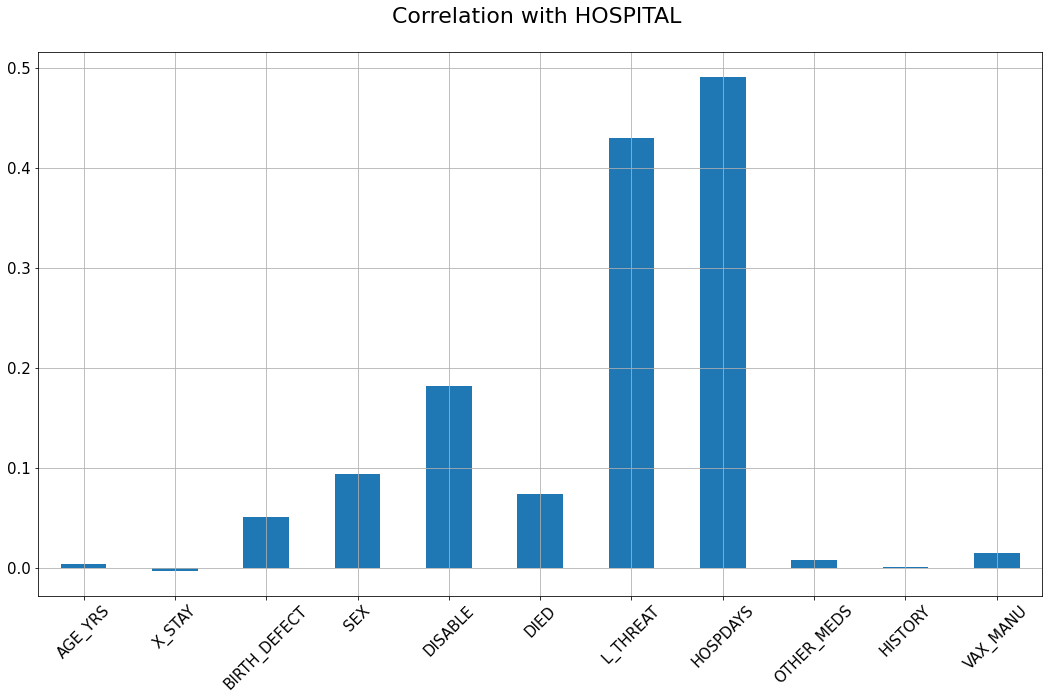

In [36]:
# plot the correlation 
correlations.plot.bar(
        figsize = (18, 10), 
        fontsize = 15, 
        rot = 45, grid = True)

plt.title('Correlation with HOSPITAL \n',
horizontalalignment="center", fontstyle = "normal", 
fontsize = "22")

In [37]:
#set the target column
target = df_vax_and_data["HOSPITAL"]

# set the features 
model_df = df_vax_and_data.drop(columns="HOSPITAL")

In [35]:
# training models 
model_1=['Random Forest',RandomForestClassifier(n_estimators=100, criterion = 'entropy', random_state = 92)]
model_2=['SVM',SVC(kernel = 'rbf', random_state = 90)]
model_3= ['Logistic Regression',LogisticRegression(solver='liblinear', random_state = 105,class_weight='balanced')]
model_4= ['Decision Tree',DecisionTreeClassifier(criterion = 'entropy', random_state = 90)]
model_5 = ['Gradient Boosting Classifier',GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=1, random_state=0)]

models=[model_1,model_2,model_3,model_4,model_5]

In [36]:
# normalize the data 
# Standardize features by removing the mean and scaling to unit variance
sc_X = StandardScaler()

model_df_norm = pd.DataFrame(sc_X.fit_transform(model_df))

model_df_norm.columns = model_df.columns.values

model_df_norm.index = model_df.index.values

model_df_1 = model_df_norm

In [37]:
def cross_validation(X, y, model):
    
    X, y = np.array(X), np.array(y)
    
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    results = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model.fit(X_train, y_train)
        y_hat = model.predict(X_test)
        results.append(accuracy_score(y_test, y_hat))
        
    return np.mean(results), np.std(results)

In [38]:

# a list for training infos 
traing_info=[]

for m in models:
    res=cross_validation(model_df_1,target,m[1])
    dict_model = {"model_name":m[0],"accuracy_mean":res[0],"accuracy_std":res[1]}
    traing_info.append(dict_model)

# create a new dataframe 
model_vali_df = pd.DataFrame()

# for each dict. in dict. list add to the last dataframe 
for l in traing_info:
    model_vali_df=model_vali_df.append(l, ignore_index=True)

In [ ]:
model_vali_df[['model_name','accuracy_mean', 'accuracy_std']].sort_values('accuracy_mean',ascending=False)

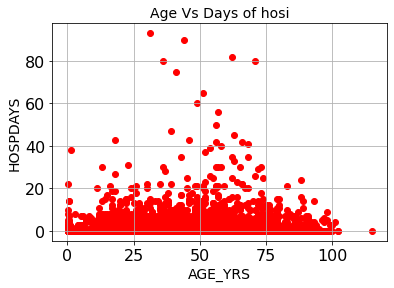

In [43]:
plt.scatter(df_data_coor['AGE_YRS'], df_data_coor['HOSPDAYS'], color='red')
plt.title('Age Vs Days of hosi', fontsize=14)
plt.xlabel('AGE_YRS', fontsize=14)
plt.ylabel('HOSPDAYS', fontsize=14)
plt.grid(True)
plt.show()

In [ ]:
df_data_coor_no_nan = df_data_coor.dropna()
print(df_data_coor_no_nan.shape)
df_data_coor_no_nan[df_data_coor_no_nan.isna().any(axis=1)]

df_vax_and_data.columns

In [44]:
from sklearn.linear_model import Lasso, Ridge
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline

y = df_vax_and_data['HOSPDAYS']
X = df_vax_and_data.drop(['VAERS_ID_DATA', 'HOSPDAYS'], axis=1)

model_l = Lasso(alpha=1)
model_R = Ridge(alpha=1)

### make CV pipeline
alphas = [0.000001,0.00001,0.0001, 0.001, 0.01 , 0.05 , 0.1 , 1 , 10 , 50 , 100 , 500, 1000 , 5000,10000, 100000, 10000000 ]

ridge_val = []

for a in alphas:
  model_R = Ridge(alpha=a)
  ridge_val.append(sum(cross_val_score(model_R, X, y, cv=5,  scoring="neg_mean_absolute_error")))

print("Best found Alpha Value For Ridge Model: ", alphas[ridge_val.index(max(ridge_val))])

lasso_val = []
for a in alphas:
  model_L = Lasso(alpha=a)
  lasso_val.append(sum(cross_val_score(model_R, X, y, cv=5,  scoring="neg_mean_absolute_error")))


print("Best found Alpha Value For LASSO Model: ", alphas[lasso_val.index(max(lasso_val))])

# TODO

# model1.fit(X_train,y_train)
# y_pred1 = np.array(model1.predict(X_train))
# RMSE_1=np.sqrt(np.sum(np.square(y_pred1-y_train)))
# print("Root-mean-square error of Metamodel:",RMSE_1)
# coeff1 = pd.DataFrame(model1.coef_,index=df_poly.drop('y',axis=1).columns, columns=['Coefficients Metamodel'])
# model1.score(X_train,y_train)
# model1.alpha_
# coeff1[coeff1['Coefficients Metamodel']!=0]

Best found Alpha Value For Ridge Model:  500
Best found Alpha Value For LASSO Model:  1e-06


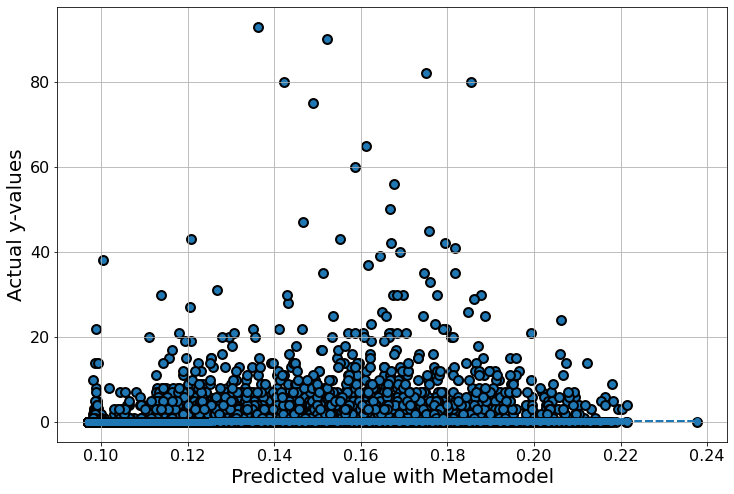

In [45]:
model_R.fit(X,y)
y_pred1 = np.array(model_R.predict(X))

plt.figure(figsize=(12,8))
plt.xlabel("Predicted value with Metamodel",fontsize=20)
plt.ylabel("Actual y-values",fontsize=20)
plt.grid(1)
plt.scatter(y_pred1,y,edgecolors=(0,0,0),lw=2,s=80)
plt.plot(y_pred1,y_pred1, 'o--', lw=2)